## Eye localization and closed eye detection(ELCED)

### 1) Localization with region proposal and CNN
For the first approach we want to show the steps of the processing pipeline from face detection to region proposal
to classification. For the face detection we have used an existing implementation which can be found at: https://github.com/ageitgey/face_recognition

In [1]:
# imports from data_preperation include all functions necessary for the face detection to patch proposal
from data_preperation import *
from scipy.signal import convolve2d
from scipy.misc import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, feature, color, img_as_float
import skimage.filters as filter
import warnings
warnings.filterwarnings('ignore')

In [2]:
''' we load the files of the BioID into a filelist,
thereafter we generate an subsampled dataset of the images, face locations and cropped images '''
# filelist for the images
filelist = load_filelist()
images  = load_Images(filelist)[400:450]
face_loc = get_face_loc(images)
# filelist for the eye positions
filelist_eye_positions = load_filelist(type='eye')
eye_positions = load_eye_position(filelist_eye_positions)[400:450]
(images, face_loc, eye_positions) = remove_negatives(images,face_loc,eye_positions)
# images gained by face detection
cropped = crop_images(images, face_loc)

#### Showing an example of the DoG Gaussian convolution

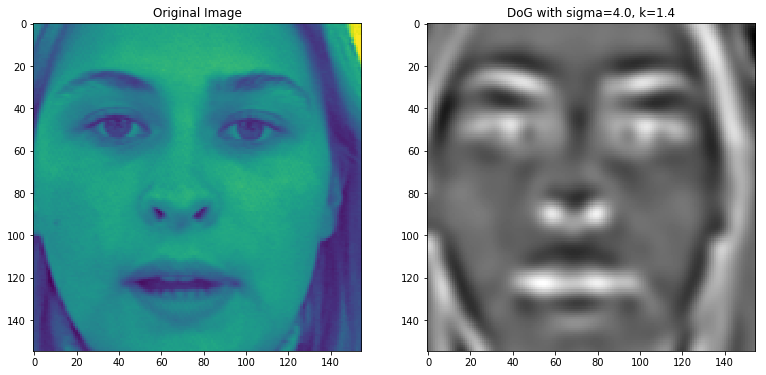

In [3]:
test_image = cropped[26]

plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.imshow(test_image)
plt.title('Original Image')
img = test_image

# factor for gauss difference
k = 1.4
# the two gaussians
sigma = 4.0
s1 = filter.gaussian(img,k*sigma)
s2 = filter.gaussian(img,sigma)

# multiply by sigma to get scale invariance
dog_ = s1 - s2
plt.subplot(2,3,2)
plt.imshow(dog_, cmap='gray')
plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(k))
    
    
plt.show()

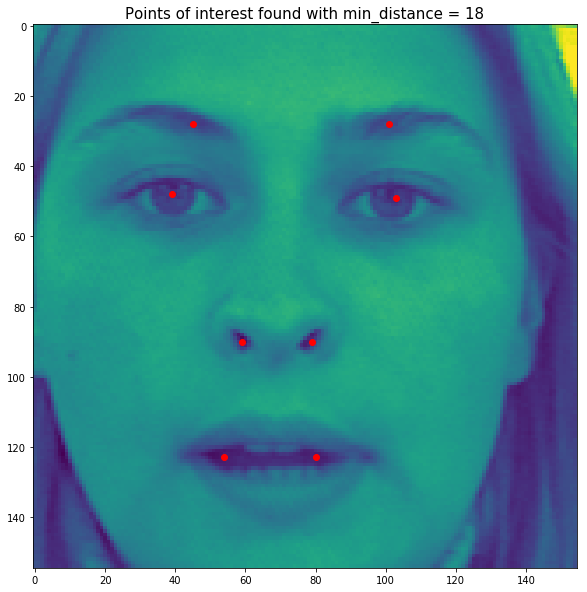

In [4]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
'''Showing the Blobs found for the example image'''
proposed_blobs = peak_local_max(dog_, min_distance=18)
plt.figure(figsize=(10,10))
plt.imshow(test_image)
plt.title('Points of interest found with min_distance = 18', fontsize=15)
plt.scatter(proposed_blobs[:,1], proposed_blobs[:,0], c='r')
plt.show()

#### Now we want to classify the proposed patches with the CNN

In [2]:
from CNN_eyes import CNN,train_model,test_model,predict, convert_to_FloatTensor
import torch

Patches classified as eyes


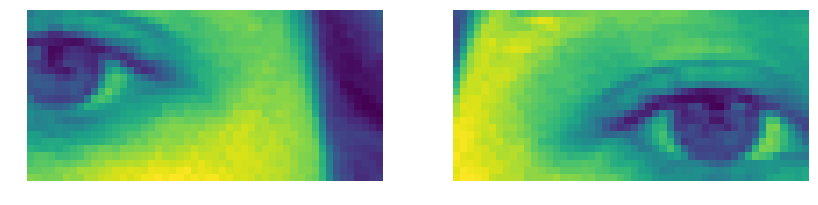

In [6]:
# load the model from checkpoint
M = CNN()
M.load_state_dict(torch.load('data_final/CNN_eyes_goodModel.ckpt'))

# cropping the patches
image_patches = crop_bounding_box(test_image, proposed_blobs)
predictions = np.array([torch.argmax(M(convert_to_FloatTensor(patch))).numpy() for patch in image_patches])

# get the patches where the prediction == 1
print('Patches classified as eyes')
eye_idx = np.where(predictions == 1)[0]
fig, ax = plt.subplots(1,2, figsize=(14,7))
for idx, axis in zip(eye_idx, ax.ravel()):
    axis.imshow(image_patches[idx])
    axis.axis('off')
plt.show()

## evaluation of the CNN approach

In [8]:
from CNN_eyes import *
from main import *
test_approach_CNN(M)

Precision = 38%, Recall = 50%
Number of individual Eyes Detected: 480 of 960
Number of False Positives: 781


### 2) Localization using semantic segmentation
For the second approach we want to show how predictions of the FCN look like and how Bounding Boxes and eyepositions are generated

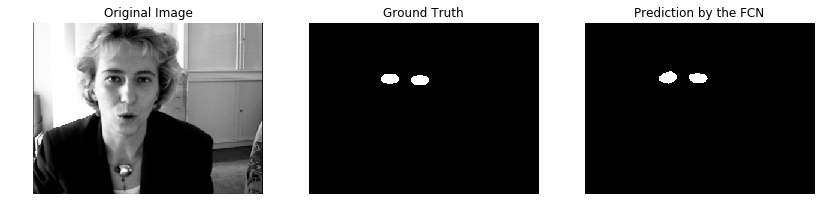

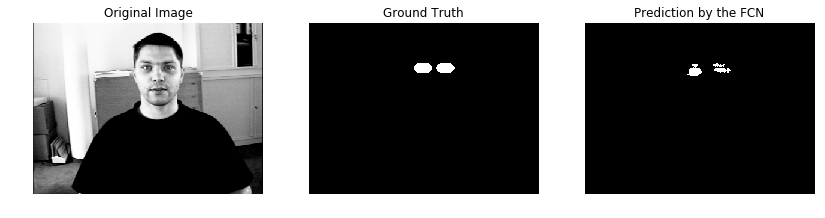

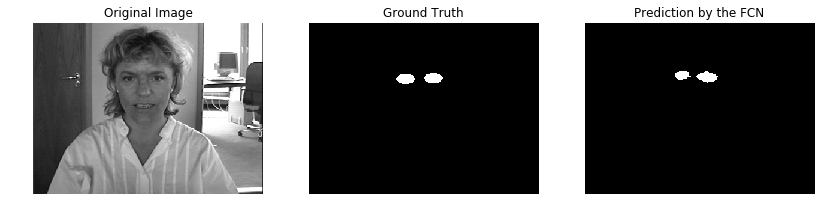

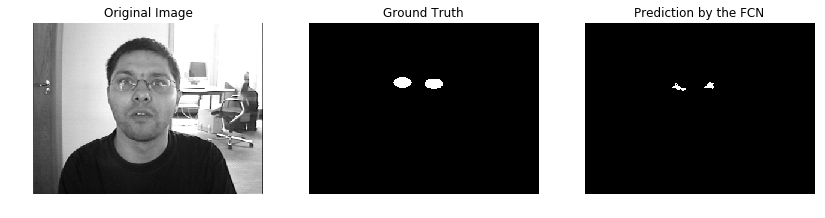

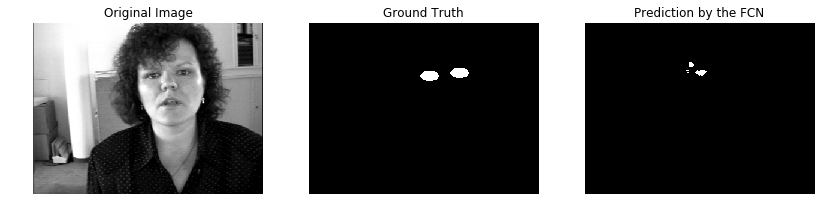

In [3]:
from FCN32 import *

# loading the test data
X = np.load('data/TestFCNX.npy')
Y = np.load('data/TestFCNY.npy')

# loading the pretrained FCN
checkpoint = 'data_final/checkpoints2/training-120.ckpt'
M = FCN32s(2)
M.load_state_dict(torch.load(checkpoint))
M.cuda()

# print some example images with gt and segmentation map
for i in range(30,71 , 10):
        ex = torch.FloatTensor(X[i]).cuda()
        ex = ex.view(1,1,286,384)

        prediction = M(ex)
        pred1 = prediction[0][0].cpu().detach().numpy()
        pred2 = prediction[0][1].cpu().detach().numpy()
        
        plt.figure(figsize=(14,7))
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(X[i], cmap='gray')
        plt.title('Original Image')
        
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(Y[i], cmap='gray')
        plt.title('Ground Truth')
        
        plt.subplot(133)
        img = np.greater(pred2, pred1)*255
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Prediction by the FCN')
        
        plt.show()

#### The predictions we received were not to precise pixelwise but were at the right location, which results in good eye locatlization. We will now show the process of generating the bounding boxes

In [11]:
from main import *
    
# convert Model to cuda for faster prediction
M = M.cuda()
predictions = np.array([get_prediction(M(to_cuda(x))) for x in X])

In [21]:
import cv2
'''For a given set of images and set of predictions Y draw bounding boxes on top of the images'''
def draw_BB(X, Y):
    for i in range(len(Y)):
        boxes = get_BB(Y[i])
        for box in boxes:
            (x, y, w, h) = box
            cv2.rectangle(X[i], (x, y), (x+w, y+h), (255, 0, 0), 2)

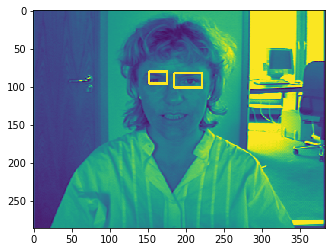

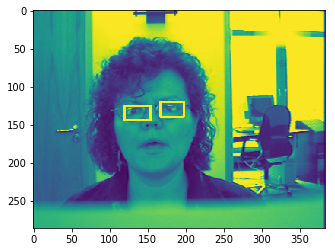

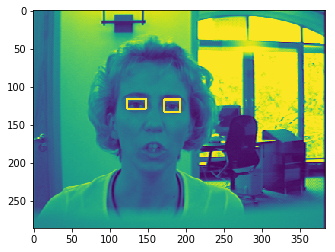

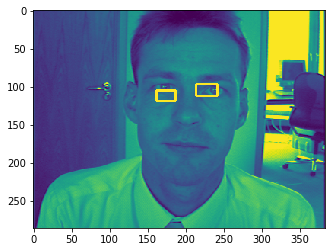

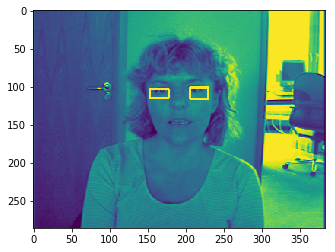

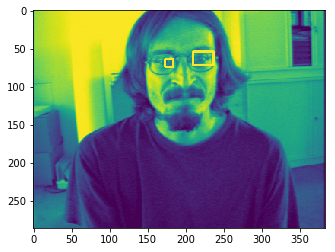

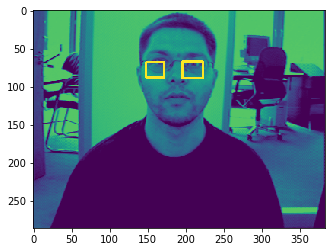

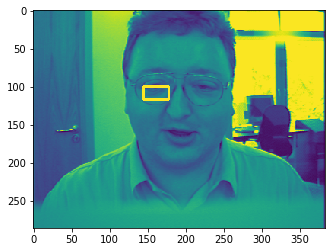

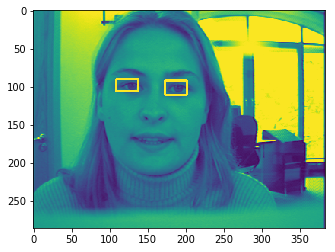

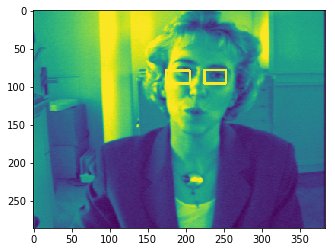

In [25]:
# draw the boxes for the first 100 images and 100 predictions
draw_BB(X[50:60], predictions[50:60])

# draw images with overlayed BB
for i in range(10):
    plt.imshow(X[i+50])
    plt.show()

### Evaluating the performance of the FCN
We evaluate the performance of the FCN by mean of mean Intersect over Union. We also give percentages of true positives, false positives and false negatives for additional information.

In [14]:
from main import eval
# evaluate on test set
testX = np.load('data/TestFCNX.npy')
testY = np.load('data/TestFCNY.npy')

accuracy, tp, fp, fn = eval(M, testX, testY)

print('Performance on the testset')
print('\nMean IoU = {}%'.format(round(accuracy*100)))
print('true_positives = {}%'.format(round(tp*100)))
print('false_positives = {}%'.format(round(fp*100)))
print('false_negatives = {}%'.format(round(fn*100)))

# evaluate on train set
trainX = np.load('data/TrainFCNX.npy')
trainY = np.load('data/TrainFCNY.npy')
accuracy, tp, fp, fn = eval(M, trainX, trainY)

print('\nPerformance on the training set')
print('\nMean IoU = {}%'.format(round(accuracy*100)))
print('true_positives = {}%'.format(round(tp*100)))
print('false_positives = {}%'.format(round(fp*100)))
print('false_negatives = {}%'.format(round(fn*100)))


Performance on the testset

Mean IoU = 35.0%
true_positives = 35.0%
false_positives = 45.0%
false_negatives = 20.0%

Performance on the training set

Mean IoU = 69.0%
true_positives = 69.0%
false_positives = 19.0%
false_negatives = 12.0%


### Evaluating the eye localization of the FCN
We now test how good the eye localization of the FCN works on both training and testsplit. We then report precision and recall.

In [15]:
from main import test_approach_FCN
# performance on train split
tp, fp, fn = test_approach_FCN(M, split='train')


# performance on test split
tp, fp, fn = test_approach_FCN(M, split='test')


precision = 99%
recall = 94%
precision = 90%
recall = 77%
